# Macchie Solari
Numero medio mensile totale di macchie - dal 1749 a luglio 2018

## **Contesto**

Le macchie solari sono fenomeni temporanei sulla fotosfera del Sole che appaiono come macchie più scure delle aree circostanti. Sono regioni di temperatura superficiale ridotta causata da concentrazioni di flusso di campo magnetico che inibiscono la convezione. Le macchie solari di solito appaiono in coppie di polarità magnetica opposta. Il loro numero varia a seconda del ciclo solare di circa 11 anni.

### TIME SERIES

#### Importazione delle librerie e dei dati

In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

In [2]:

path = '/content/Sunspots.csv'
df = pd.read_csv(path)
df.head(5)

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


### Pulizia e visualizzazione

### Analisi preliminare

In [3]:
df.columns

Index(['Unnamed: 0', 'Date', 'Monthly Mean Total Sunspot Number'], dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3265 non-null   int64  
 1   Date                               3265 non-null   object 
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.7+ KB


Ci accorgiamo che la data non è nel formato corretto, procediamo quindi alla conversione

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Unnamed: 0                         3265 non-null   int64         
 1   Date                               3265 non-null   datetime64[ns]
 2   Monthly Mean Total Sunspot Number  3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 76.7 KB


Una caratteristica importante nella gestione delle time series, è che l'indice della serie deve essere la colonna delle date.

In [6]:
df.set_index('Date', inplace=True)
df.head()

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7


### Pulizia dati

Andiamo a verificare la presenza di valori mancanti, che il software non riesce a gestire.

In [7]:
df.isnull().sum()

,0
Unnamed: 0,0
Monthly Mean Total Sunspot Number,0


### Pre-Processing

## Standardizzazione

Procediamo con la standardizzazione dei valori numerici.

In [8]:
scaler = StandardScaler()
df_standard = df.copy()
df_standard['Monthly Mean Total Sunspot Number'] = scaler.fit_transform(df[['Monthly Mean Total Sunspot Number']])


# Augmented Dickey-Fuller

Utilizziamo il metodo Augmented Dickey-Fuller per capire se la serie è stazionaria, ovvero se sono assenti componenti quali ad esempio stagionalità o ciclicità.

In [9]:
result = adfuller(df['Monthly Mean Total Sunspot Number'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.497052
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Un p-value nullo indica la stazionarietà della serie.

<Axes: xlabel='Date'>

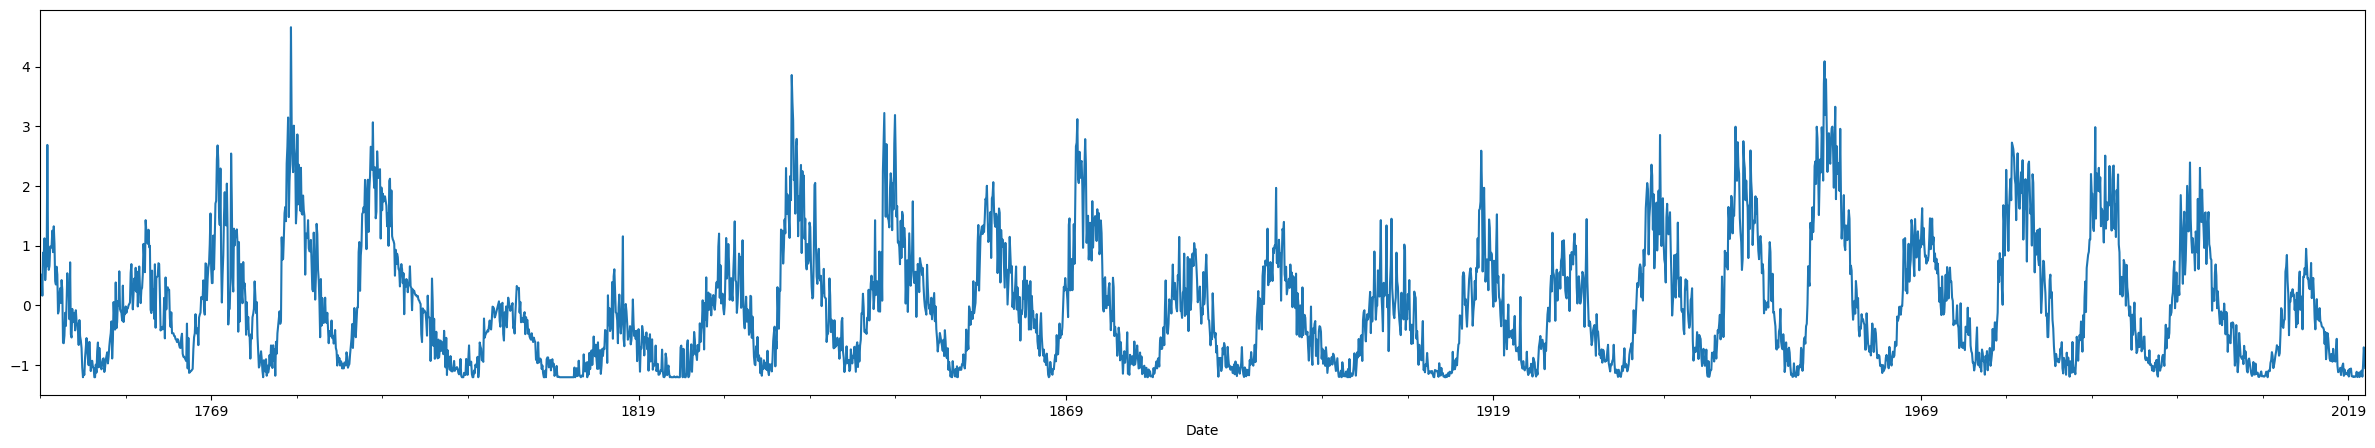

In [10]:
df_standard['Monthly Mean Total Sunspot Number'].plot(figsize=(30,5))

Effettivamente, la serie subisce solo una stagionalità molto ridotta, ma comunque perfettamente trattabile.

### Ricerca dei parametri per il modello ARIMA

### Parametro d

Essendo la serie stazionaria, ed essendo d il parametro di differenziazione che ha come scopo proprio rendere la serie stazionaria, ci aspettiamo che sia zero.

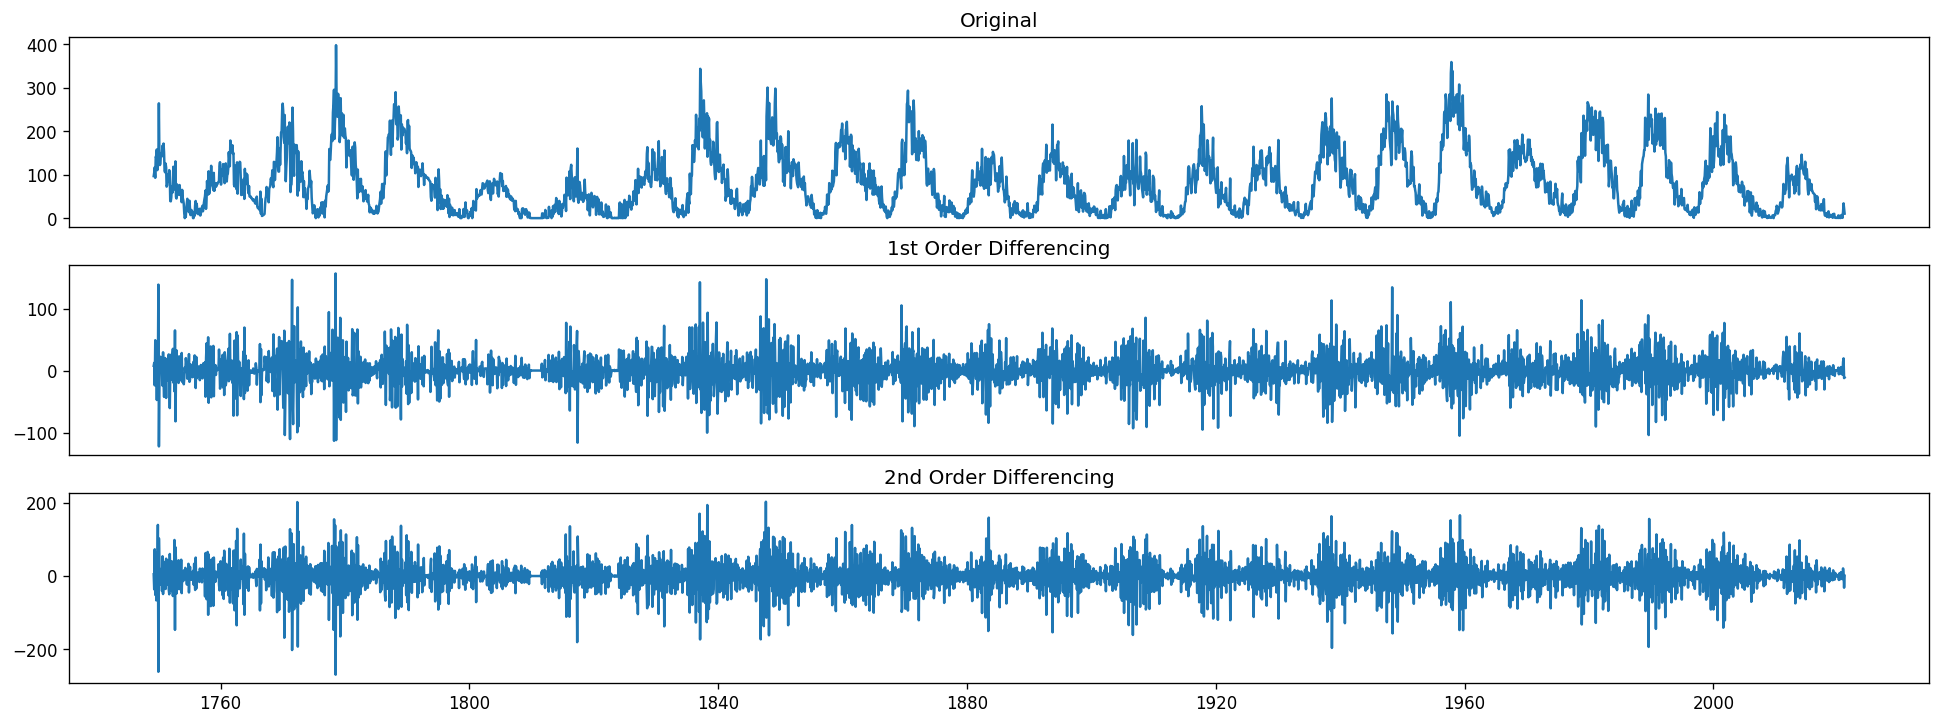

In [11]:
plt.rcParams.update({'figure.figsize':(20,7), 'figure.dpi':120})
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df['Monthly Mean Total Sunspot Number']); ax1.set_title('Original'); ax1.axes.xaxis.set_visible(False)
ax2.plot(df['Monthly Mean Total Sunspot Number'].diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
ax3.plot(df['Monthly Mean Total Sunspot Number'].diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Eseguiamo il plotting dei grafici di differenziazione ad ordini diversi

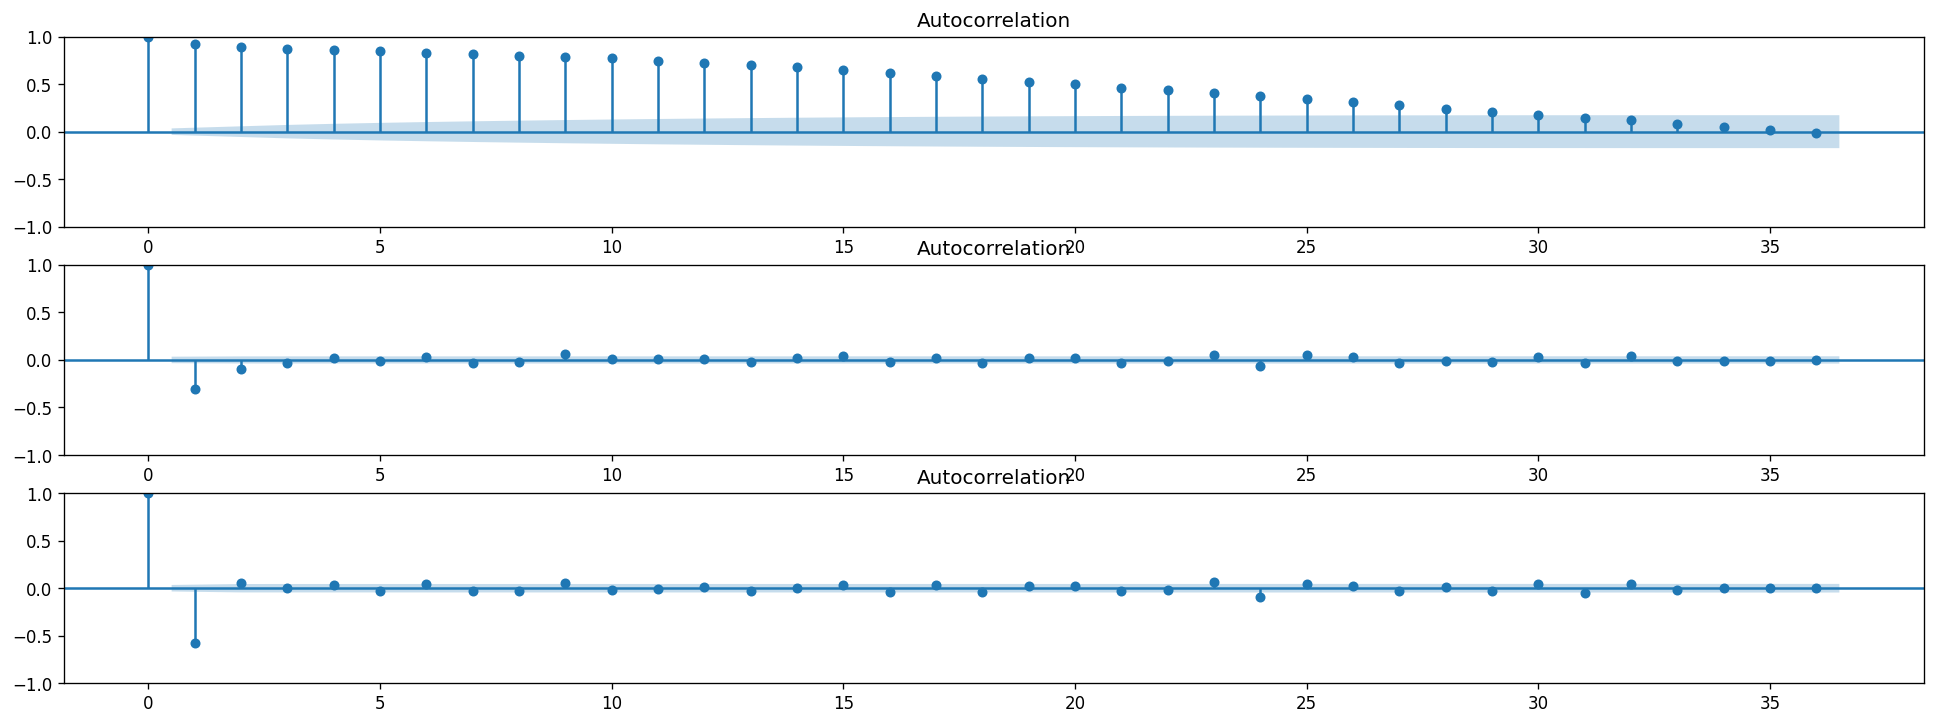

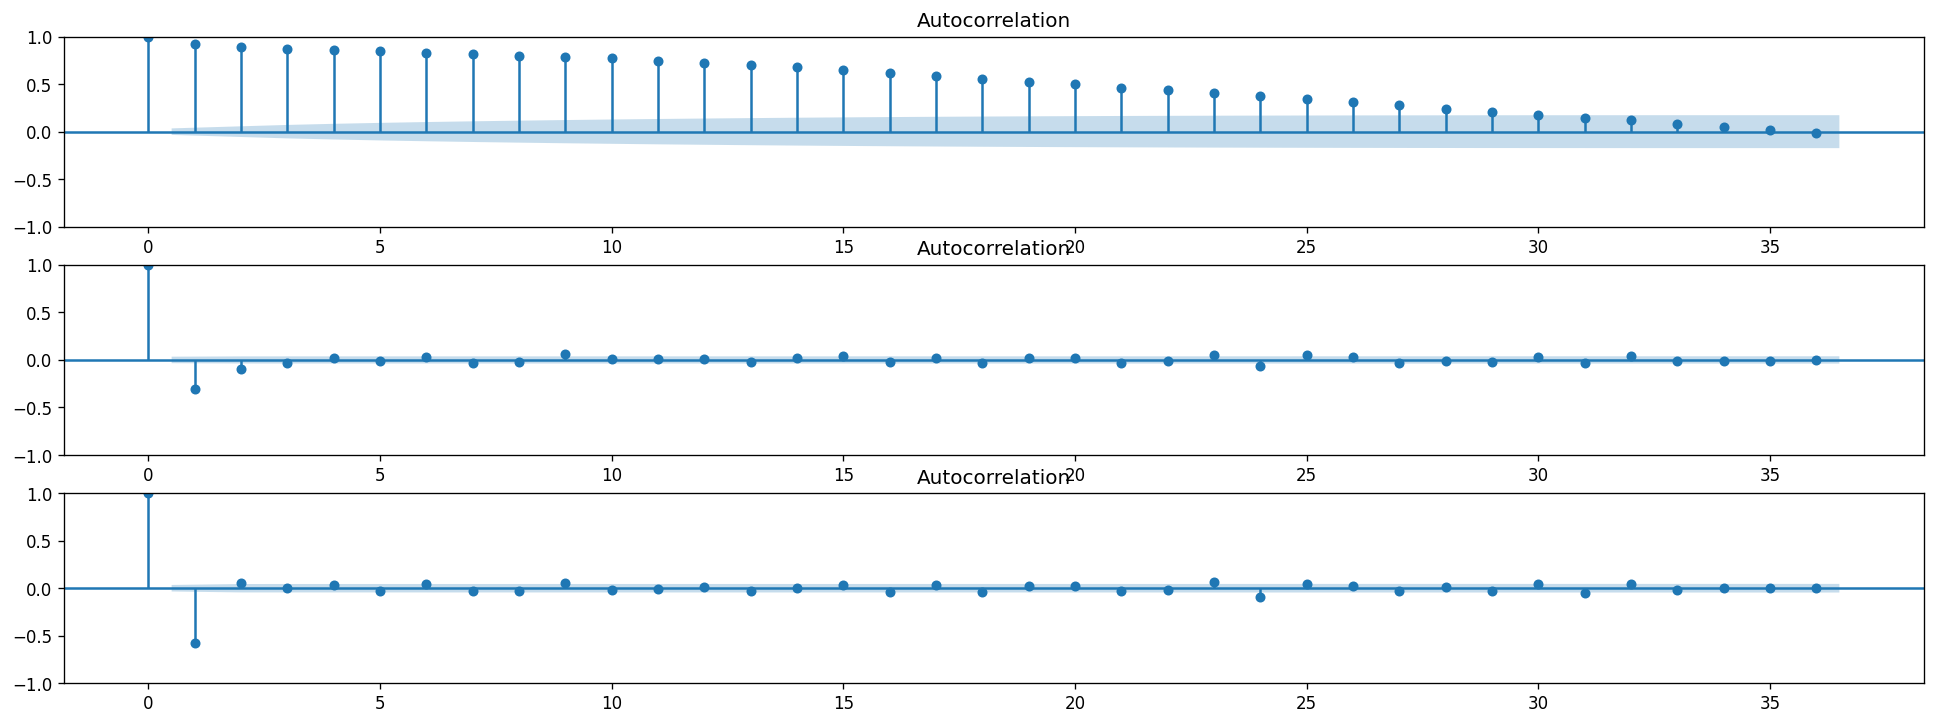

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df_standard['Monthly Mean Total Sunspot Number'], ax=ax1)
plot_acf(df_standard['Monthly Mean Total Sunspot Number'].diff().dropna(), ax=ax2)
plot_acf(df_standard['Monthly Mean Total Sunspot Number'].diff().diff().dropna(), ax=ax3)

Effettivamente già alla prima differenziazione, il secondo lolly-pop subisce ribaltamento. Questo vuol dire che d è effettivamente nullo.

### Parametro p

Andiamo dunque a stimare p cercando nel grafico relativo all'ordine di differenziazione d=0, il numero dei primi "lolly-pop", escluso il primo a sinistra, che escono dallarea di confidenza del grafico PACF.

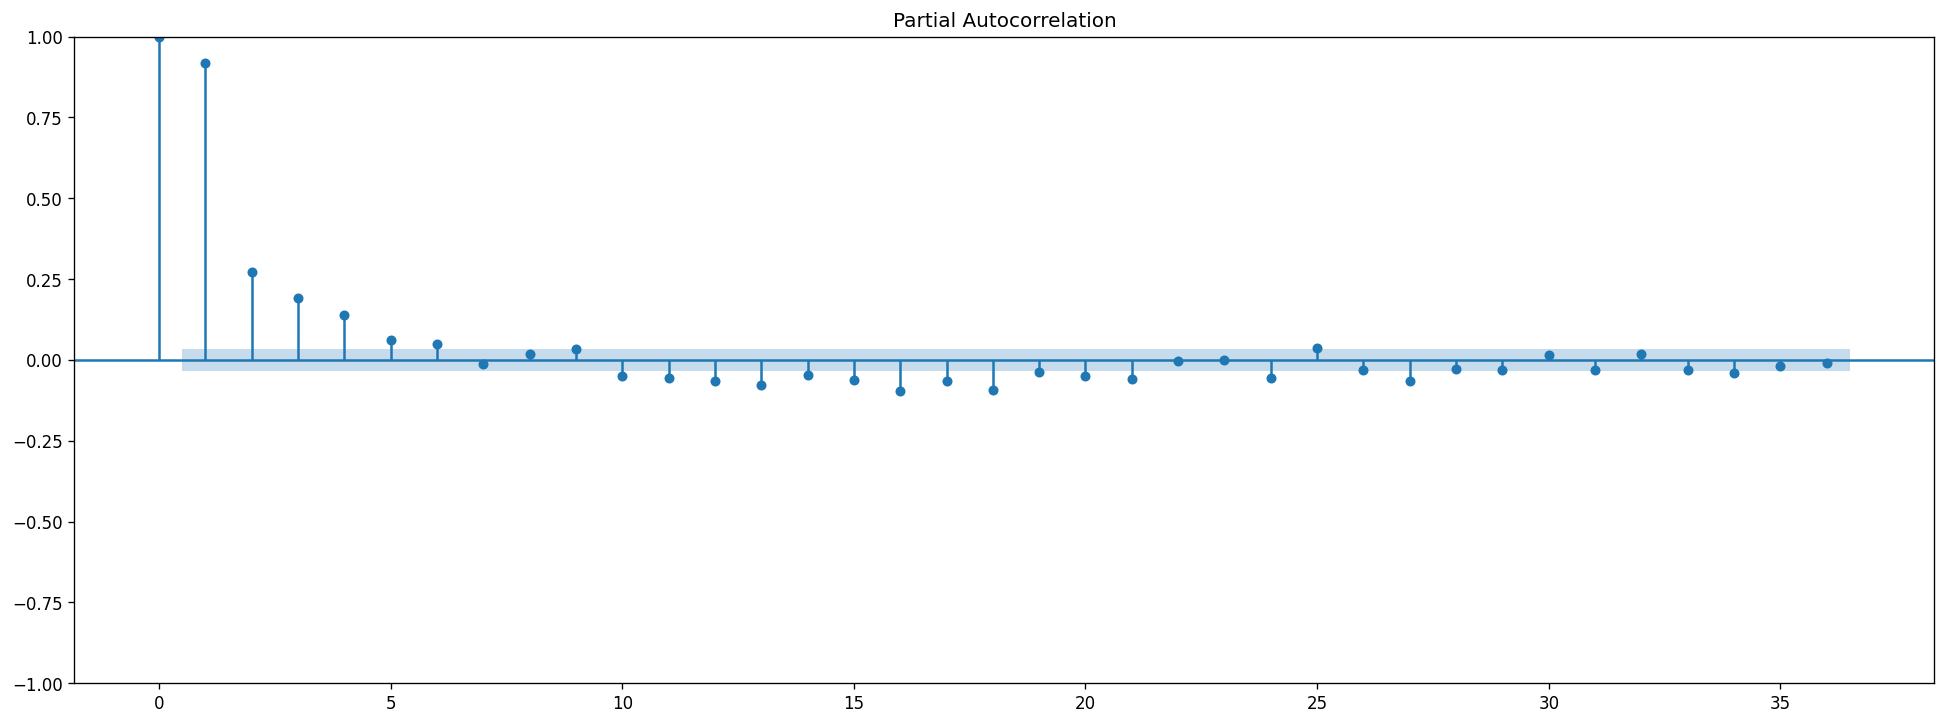

In [13]:
plot_pacf(df_standard['Monthly Mean Total Sunspot Number'])
plt.show()

Il corretto stimatore dl parametro è p = 5

### Parametro q

Analogamente a quanto fatto per p, usiamo il grafico ACF per stimare il valore del parametro q, anche qua dovremo rifarci al grafico relativo all'ordine di differenziazione d=0, e anche qua dovremo contare i punti che escono dalla zona di confidenza.

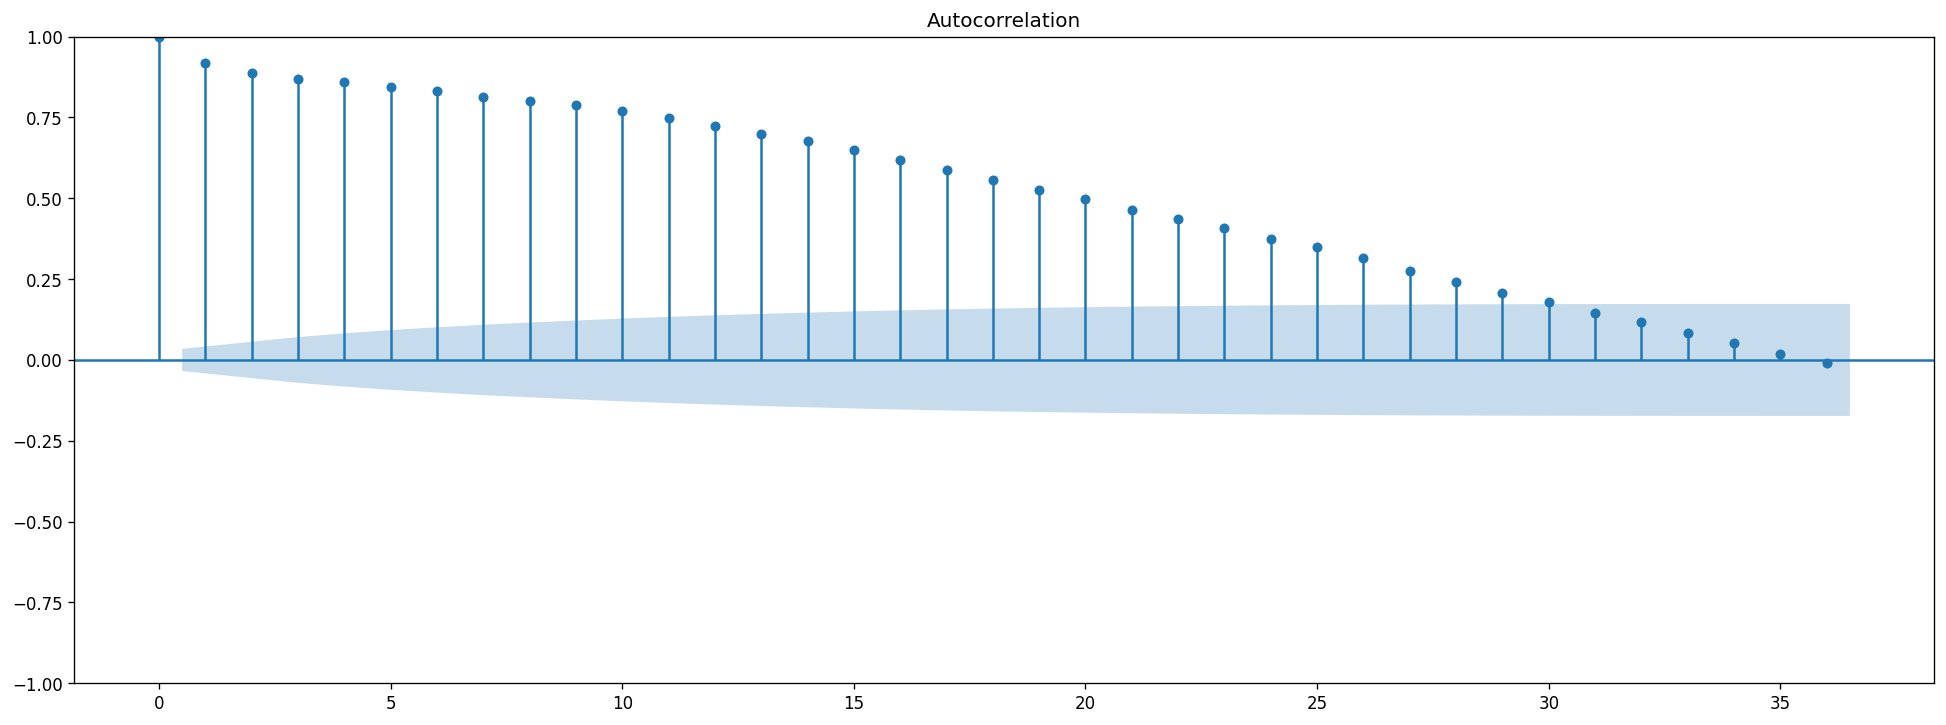

In [15]:
plot_acf(df['Monthly Mean Total Sunspot Number'])
plt.show()

Il corretto stimatore del parametro è q = 29. Questo è curioso, poichè tendenzialmente questi modelli usano numeri abbastanza bassi per questi parametri, ma la risposta è semplice: q è un parametro che si occupa di rendere la curva più smussata; in questo caso, l'andamento del grafico ACF è però molto piatto, quindi usare un valore anche molto diverso da 29, non avrà effetti determinanti circa le prevsioni del modello.

### Visualizzazione della serie nelle sue componenti

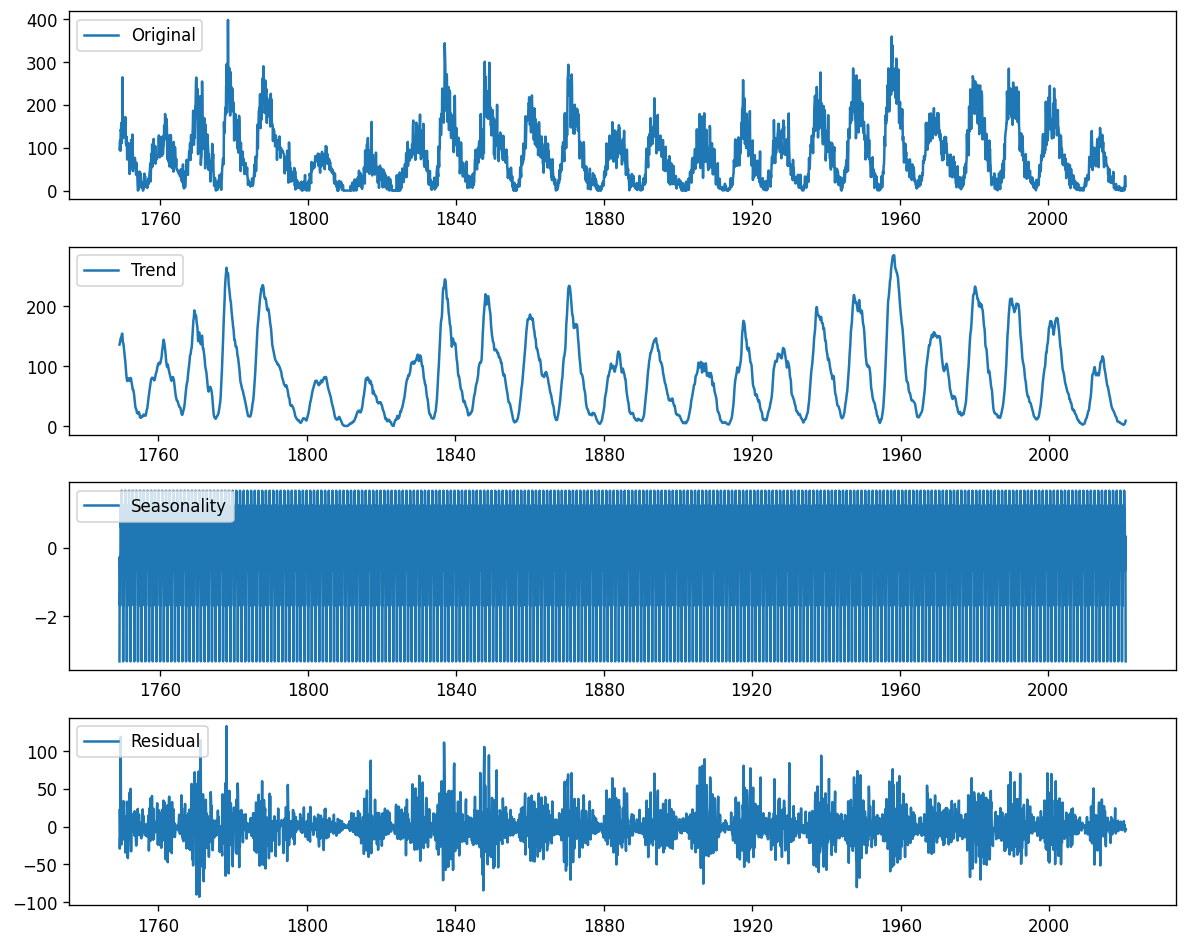

In [16]:
decomposition = seasonal_decompose(df['Monthly Mean Total Sunspot Number'])
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(df['Monthly Mean Total Sunspot Number'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### Divisione del dataset

In [27]:
train_size = int(len(df) * 0.8)
train, test = df['Monthly Mean Total Sunspot Number'][0:train_size], df['Monthly Mean Total Sunspot Number'][train_size:]
print(f"Lunghezza totale del dataset: {len(df)}")
print(f"Lunghezza del training set: {len(train)}")
print(f"Lunghezza del test set: {len(test)}")

Impostiamo delle dimensioni per la divisione del dataset e splittiamo i dati in train e test .

### Modello ARIMA

### Definizioni e train

In [28]:
model = ARIMA(train, order=(5, 0, 29))
model_fit = model.fit()
model_fit.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:     Monthly Mean Total Sunspot Number   No. Observations:                 2612
Model:                               ARIMA(5, 0, 29)   Log Likelihood              -12077.189
Date:                               Mon, 16 Jun 2025   AIC                          24226.378
Time:                                       18:06:30   BIC                          24437.621
Sample:                                   01-31-1749   HQIC                         24302.898
                                        - 08-31-1966                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.5314      7.085     11.366      0.000      66.645      94.418
ar.L1          0.6749      0.105      6.433      0.000       0.469       0.881
ar.L2          0.3489      0.129      2.704      0.007       0.096       0.602
ar.L3          0.2539      0.155      1.640      0.101      -0.049       0.557
ar.L4          0.5813      0.121      4.804      0.000       0.344       0.819
ar.L5         -0.8705      0.092     -9.478      0.000      -1.050      -0.690
ma.L1         -0.1415      0.107     -1.324      0.185      -0.351       0.068
ma.L2         -0.3298      0.103     -3.217      0.001      -0.531      -0.129
ma.L3         -0.3650      0.133     -2.750      0.006      -0.625      -0.105
ma.L4         -0.7359      0.107     -6.878      0.000      -0.946      -0.526
ma.L5          0.4413      0.050      8.845      0.000       0.344       0.539
ma.L6          0.1747      0.026      6.607      0.000       0.123       0.227
ma.L7          0.0184      0.023      0.799      0.425      -0.027       0.063
ma.L8         -0.0181      0.023     -0.769      0.442      -0.064       0.028
ma.L9          0.1053      0.026      4.043      0.000       0.054       0.156
ma.L10         0.0216      0.026      0.826      0.409      -0.030       0.073
ma.L11         0.0435      0.026      1.685      0.092      -0.007       0.094
ma.L12         0.0040      0.025      0.158      0.874      -0.045       0.053
ma.L13        -0.0735      0.025     -2.909      0.004      -0.123      -0.024
ma.L14         0.0169      0.024      0.698      0.485      -0.031       0.064
ma.L15         0.0339      0.022      1.507      0.132      -0.010       0.078
ma.L16        -0.0369      0.025     -1.487      0.137      -0.086       0.012
ma.L17        -0.0093      0.025     -0.365      0.715      -0.059       0.041
ma.L18        -0.0537      0.026     -2.071      0.038      -0.105      -0.003
ma.L19        -0.0262      0.027     -0.972      0.331      -0.079       0.027
ma.L20         0.0350      0.025      1.399      0.162      -0.014       0.084
ma.L21        -0.0357      0.026     -1.369      0.171      -0.087       0.015
ma.L22         0.0106      0.027      0.391      0.696      -0.043       0.064
ma.L23         0.0681      0.027      2.523      0.012       0.015       0.121
ma.L24        -0.0333      0.028     -1.184      0.236      -0.088       0.022
ma.L25         0.0808      0.027      2.948      0.003       0.027       0.135
ma.L26         0.0211      0.024      0.884      0.376      -0.026       0.068
ma.L27        -0.0704      0.026     -2.699      0.007      -0.122      -0.019
ma.L28         0.0349      0.026      1.361      0.174      -0.015       0.085
ma.L29        -0.0542      0.025     -2.172      0.030      -0.103      -0.005
sigma2       611.4700     11.351     53.868      0.000     589.222     633.718
=========================

I parametri usati sono quelli cercati e trovati nella fase precedente.

### Previsioni

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


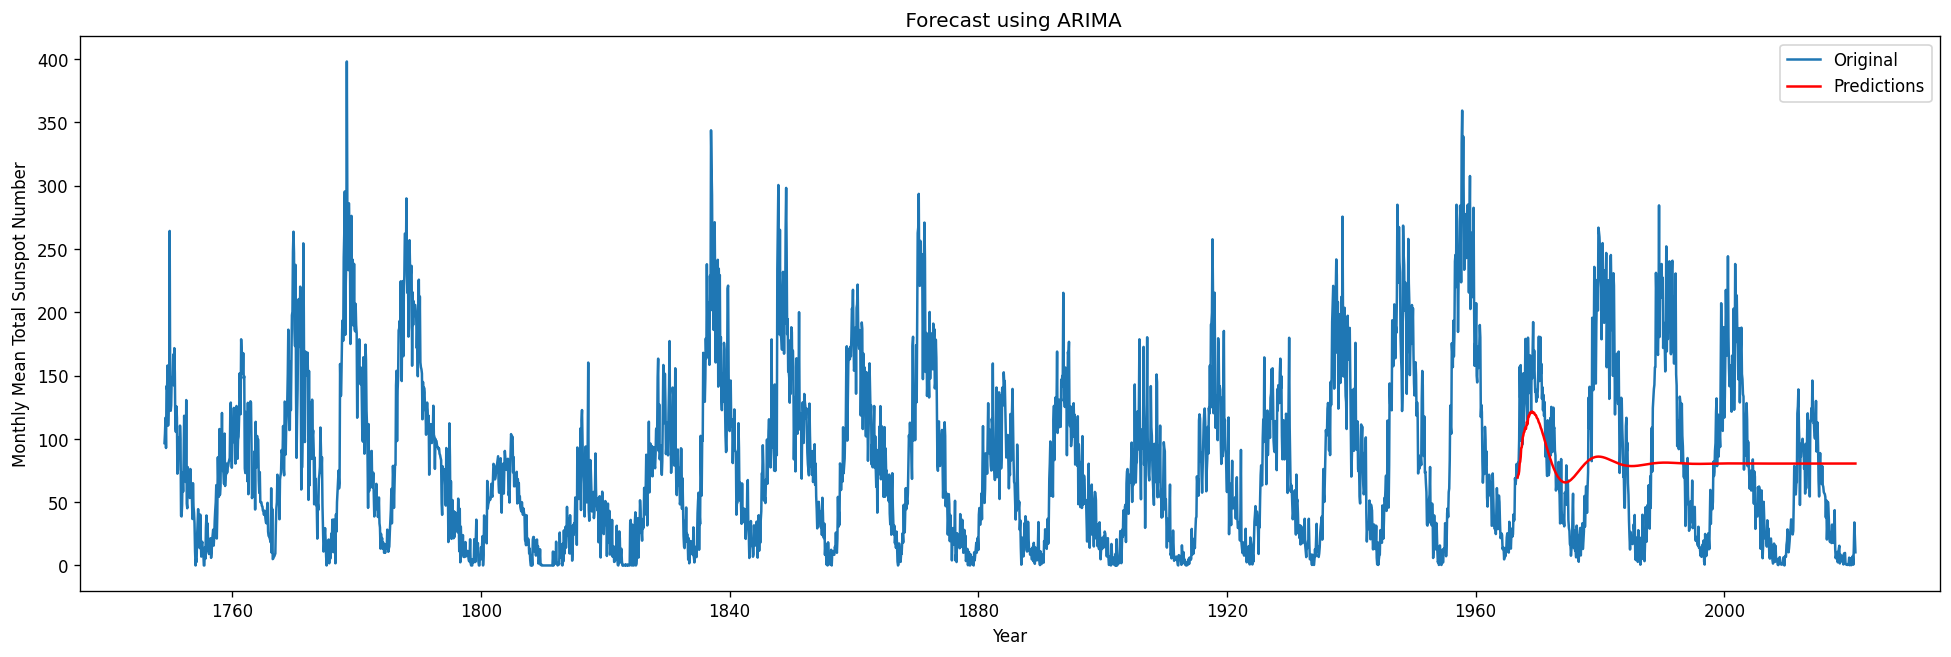

In [29]:
predictions = model_fit.predict(test_data.index.min(), test_data.index.max(), typ='levels')
plt.figure(figsize=(20, 6))
plt.plot(df['Monthly Mean Total Sunspot Number'], label='Original')
plt.plot(predictions, color='red', label='Predictions')
plt.xlabel('Year')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title(' Forecast using ARIMA')
plt.legend()
plt.show()

Eseguiamo le previsioni, logicamente, esse tenseranno ad essere via via meno accurate nel tempo, quello che ci può interssare è però cercare di capire quanto in là il nostro modello può prevedere.

### Metriche di valutazione

Utilizziamo le solite metriche di valutazione e visualizziamo i vari grafici coinvolti: train, test e predictions.

MAE: 54.909335265514024
RMSE: 66.76630788833364


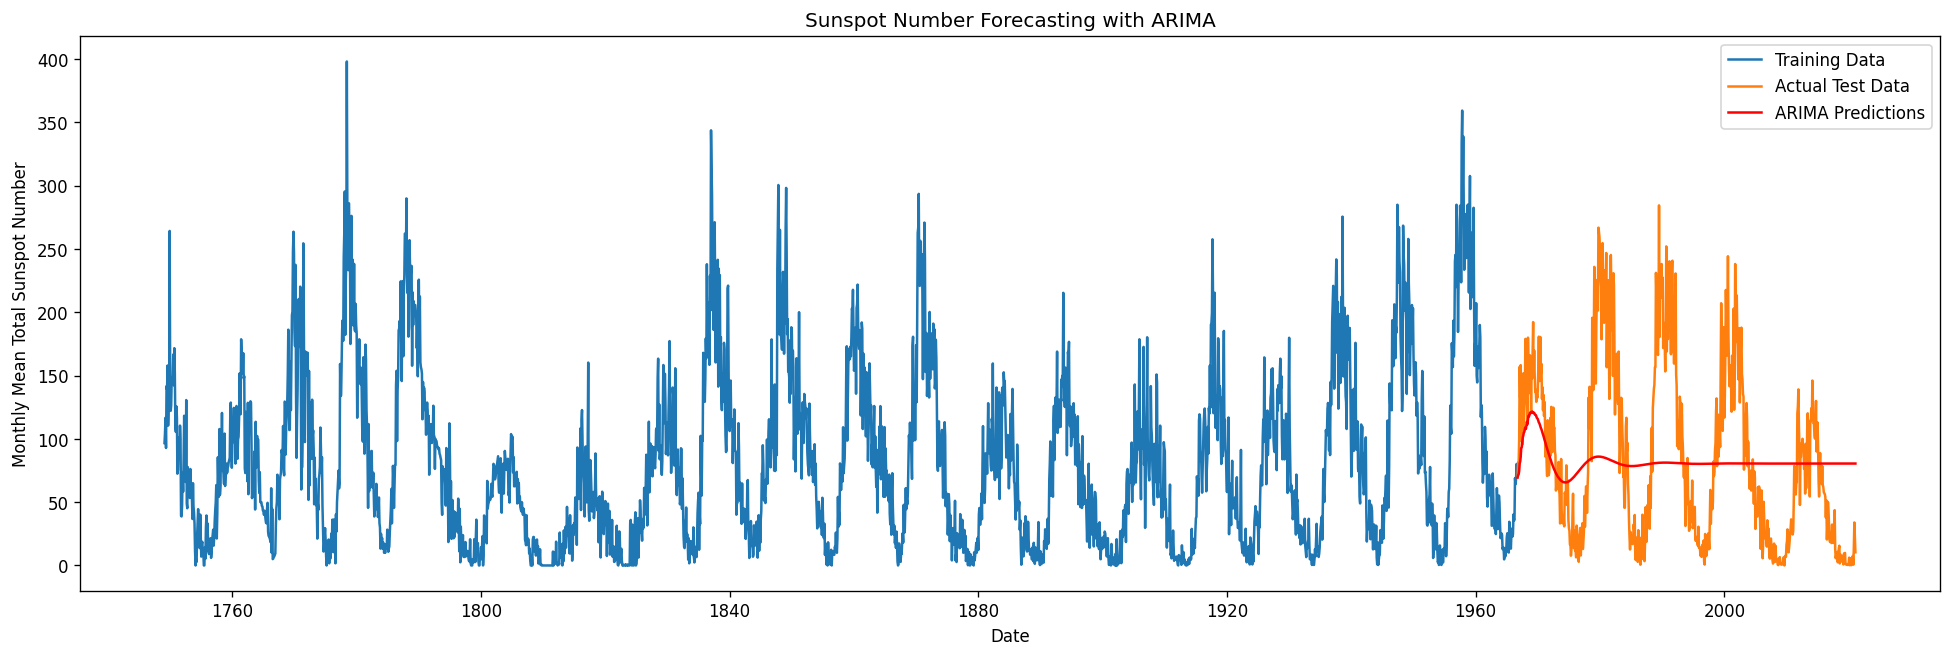

In [30]:
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
plt.figure(figsize=(20, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
plt.title('Sunspot Number Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()

I valori di errore possono sembrare elevati, ma questo è dovuto al fatto che man mano che si avanza nella previsione, il modello è sempre meno fedele e accurato, e gli errori non sono pesati in funzione della data. Cerchiamo inoltre, come ultima cosa, di visualizzare i punti in cui il modello inizia a effettuare errori troppo grandi con le previsioni; per fare ciò impostiamo una variabile di soglia (dello stesso ordine di grandezza degli errori del modello) e valutiamo in quali punti la differenza fra valore previsto e reale è maggiore di tale variabile, per poi visualizzare tutto graficamente.

I punti in cui le predizioni si scostano significativamente dai dati reali (differenza > 50) sono:
Data: 1967-01-31 00:00:00, Valore Reale: 157.00, Predizione: 80.69, Differenza: 76.31
Data: 1967-02-28 00:00:00, Valore Reale: 132.60, Predizione: 82.00, Differenza: 50.60
Data: 1967-03-31 00:00:00, Valore Reale: 158.30, Predizione: 85.80, Differenza: 72.50
Data: 1967-12-31 00:00:00, Valore Reale: 179.00, Predizione: 109.11, Differenza: 69.89
Data: 1968-01-31 00:00:00, Valore Reale: 172.50, Predizione: 107.86, Differenza: 64.64
Data: 1968-05-31 00:00:00, Valore Reale: 180.00, Predizione: 115.44, Differenza: 64.56
Data: 1969-03-31 00:00:00, Valore Reale: 192.30, Predizione: 120.42, Differenza: 71.88
Data: 1970-02-28 00:00:00, Valore Reale: 180.80, Predizione: 112.98, Differenza: 67.82
Data: 1970-05-31 00:00:00, Valore Reale: 180.50, Predizione: 109.66, Differenza: 70.84
Data: 1970-07-31 00:00:00, Valore Reale: 159.30, Predizione: 107.60, Differenza: 51.70
Data: 1975-02-28 00:00:00, Valore 

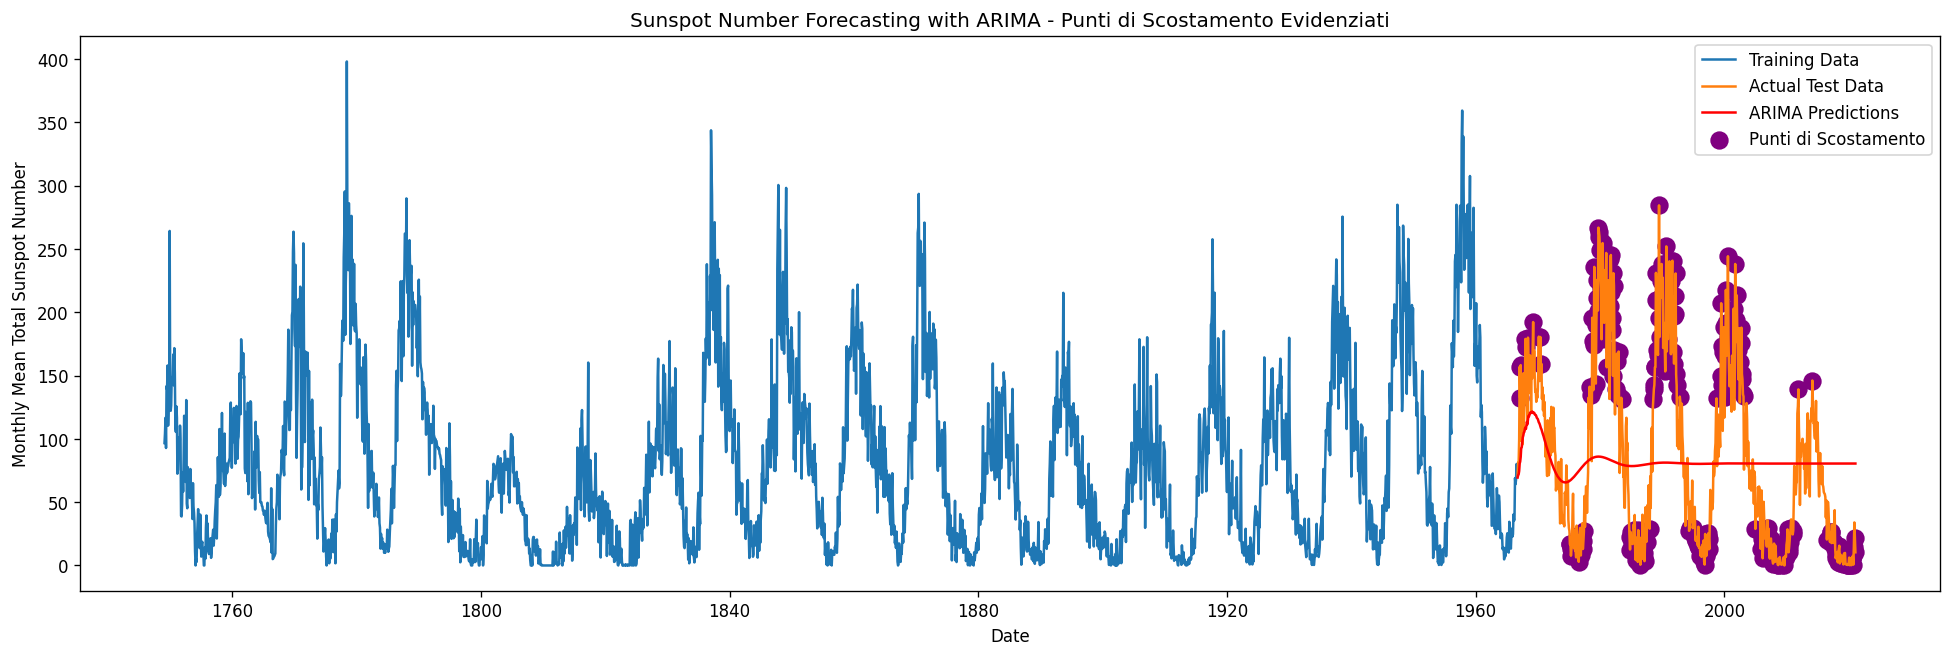


Il punto con il massimo scostamento è alla data: 1989-06-30 00:00:00
Valore Reale: 284.50, Predizione: 81.13, Massimo Scostamento: 203.37


In [36]:
soglia_differenza = 50 # Esempio di soglia
differenza_assoluta = abs(test - predictions)
indici_scostamento = differenza_assoluta[differenza_assoluta > soglia_differenza].index
if not indici_scostamento.empty:
  print(f"I punti in cui le predizioni si scostano significativamente dai dati reali (differenza > {soglia_differenza}) sono:")
  for indice in indici_scostamento:
    print(f"Data: {indice}, Valore Reale: {test.loc[indice]:.2f}, Predizione: {predictions.loc[indice]:.2f}, Differenza: {differenza_assoluta.loc[indice]:.2f}")
  plt.figure(figsize=(20, 6))
  plt.plot(train.index, train, label='Training Data')
  plt.plot(test.index, test, label='Actual Test Data')
  plt.plot(test.index, predictions, label='ARIMA Predictions', color='red')
  plt.scatter(indici_scostamento, test.loc[indici_scostamento], color='purple', s=100, label='Punti di Scostamento') # Evidenzia i punti di scostamento
  plt.title('Sunspot Number Forecasting with ARIMA - Punti di Scostamento Evidenziati')
  plt.xlabel('Date')
  plt.ylabel('Monthly Mean Total Sunspot Number')
  plt.legend()
  plt.show()
else:
  print("Non ci sono punti in cui le predizioni si scostano significativamente dai dati reali con la soglia specificata.")
indice_max_scostamento = differenza_assoluta.idxmax()
valore_max_scostamento = differenza_assoluta.max()

if not differenza_assoluta.empty:
  print(f"\nIl punto con il massimo scostamento è alla data: {indice_max_scostamento}")
  print(f"Valore Reale: {test.loc[indice_max_scostamento]:.2f}, Predizione: {predictions.loc[indice_max_scostamento]:.2f}, Massimo Scostamento: {valore_max_scostamento:.2f}")
else:
  print("\nNon ci sono differenze tra i dati reali e le predizioni.")

In conclusione, il modello ARIMA fatica a prevedere correttamente i picchi a causa della loro natura ciclica e non lineare. Dopo circa 15 anni la previsione si degrada, principalmente perché il modello utilizza solo le sue stesse predizioni come input. Proviamo per curiosità ad usare SARIMA, ma ciò che ci aspettiamo è un risultato scadente dovuto al fatto che la stagionalità della nostra serie è praticamente assente.

### SARIMA


ADF Statistic (Seasonal Diff): -8.612686
p-value (Seasonal Diff): 0.000000
Critical Values (Seasonal Diff):
	1%: -3.432
	5%: -2.862
	10%: -2.567


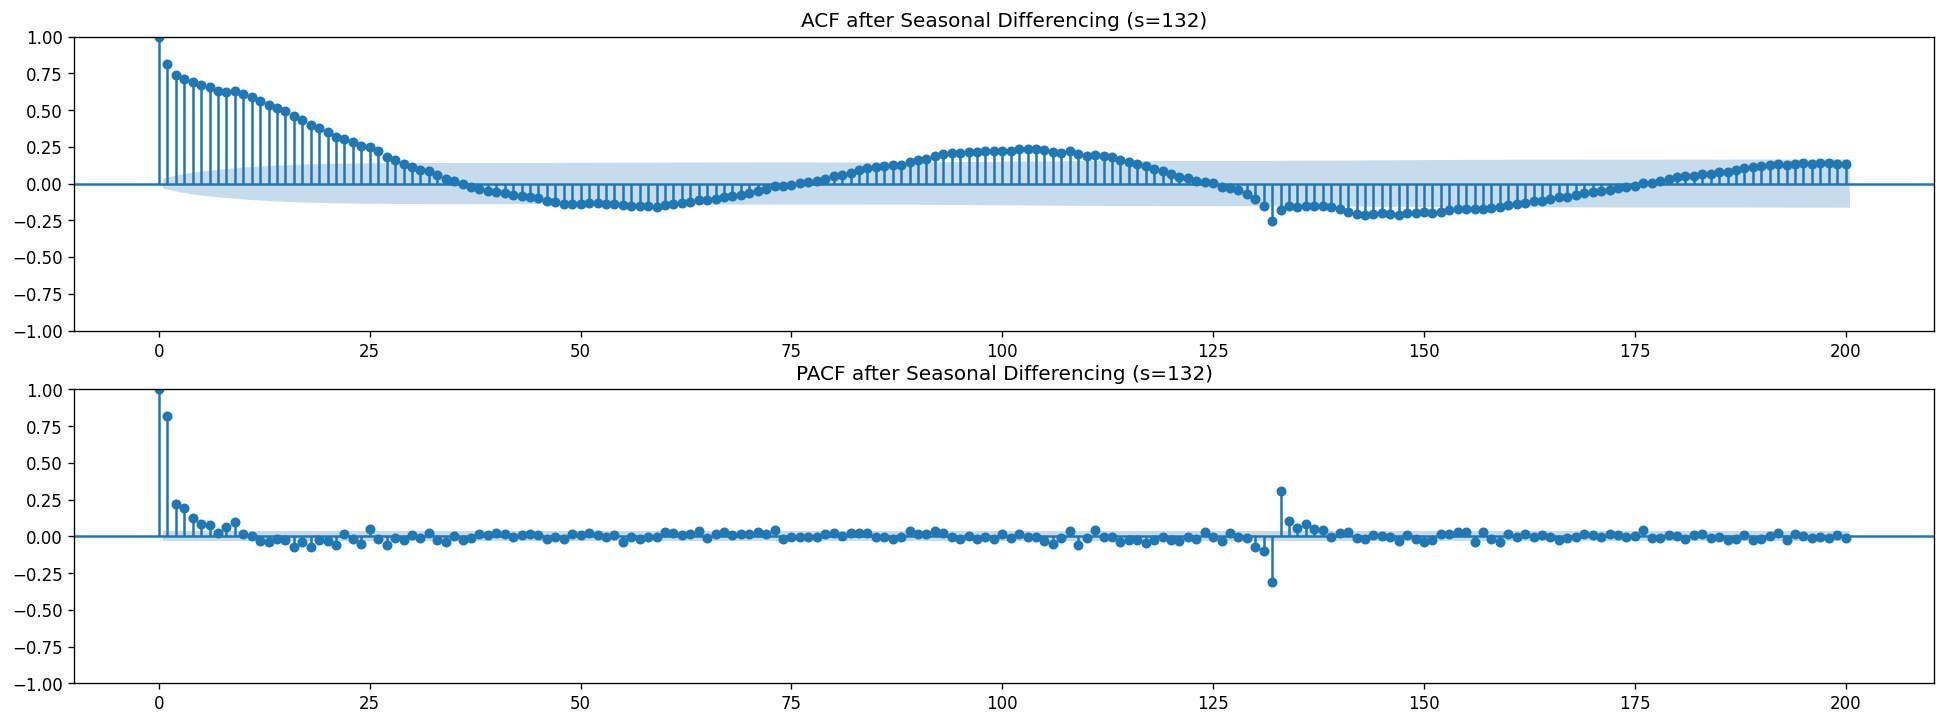

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                       SARIMAX Results                                        
Dep. Variable:      Monthly Mean Total Sunspot Number   No. Observations:                 2612
Model:             SARIMAX(5, 0, 29)x(1, 0, [1], 132)   Log Likelihood              -11367.459
Date:                                Mon, 16 Jun 2025   AIC                          22808.918
Time:                                        20:54:33   BIC                          23023.660
Sample:                                    01-31-1749   HQIC                         22886.960
                                         - 08-31-1966                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0081      0.225      4.481      0.000       0.567       1.449
ar.

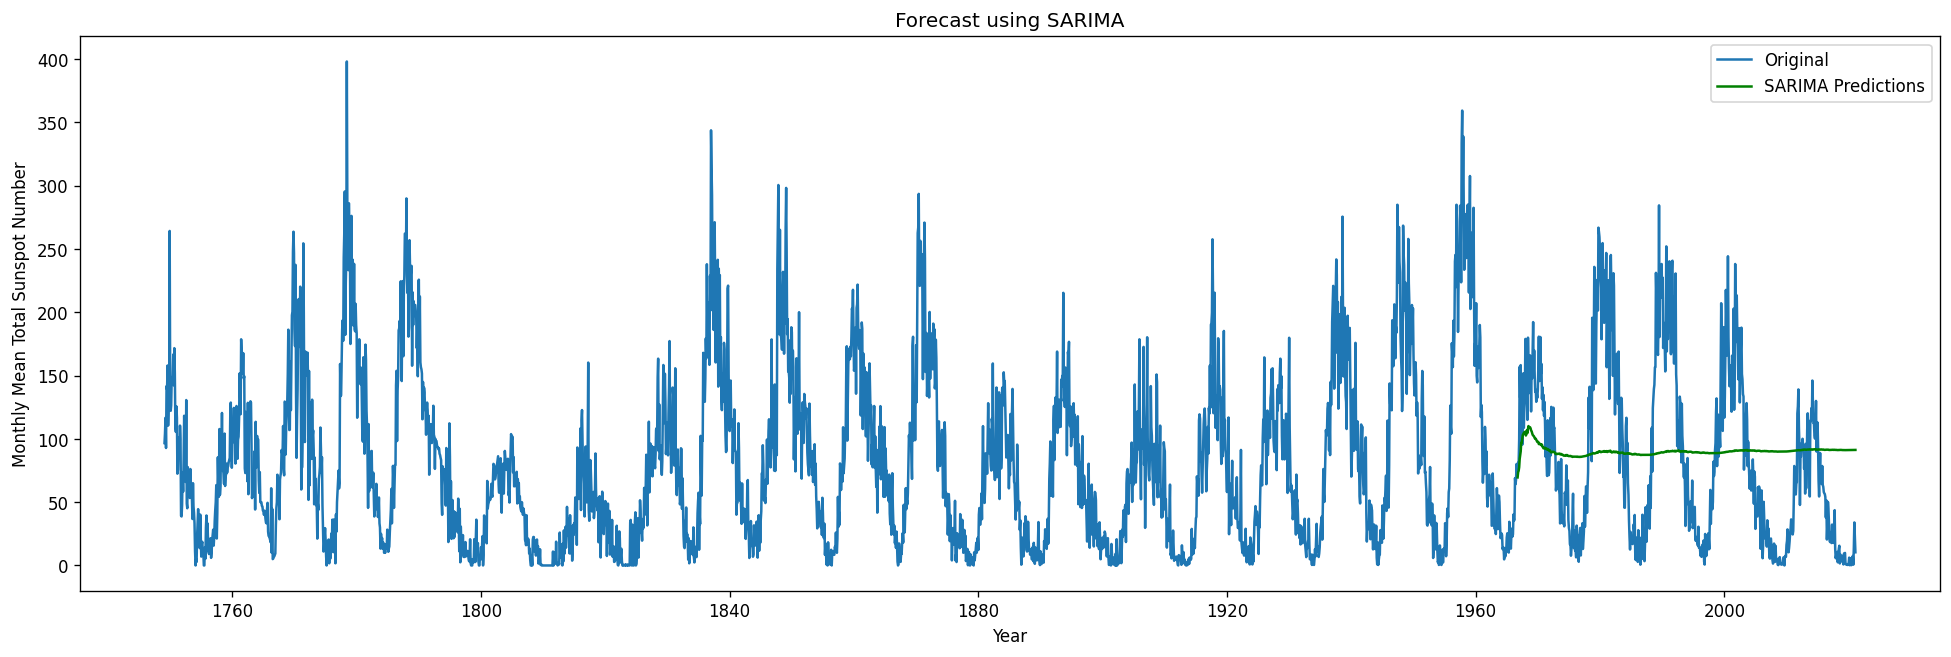

SARIMA MAE: 58.221962233740335
SARIMA RMSE: 68.57183128304763


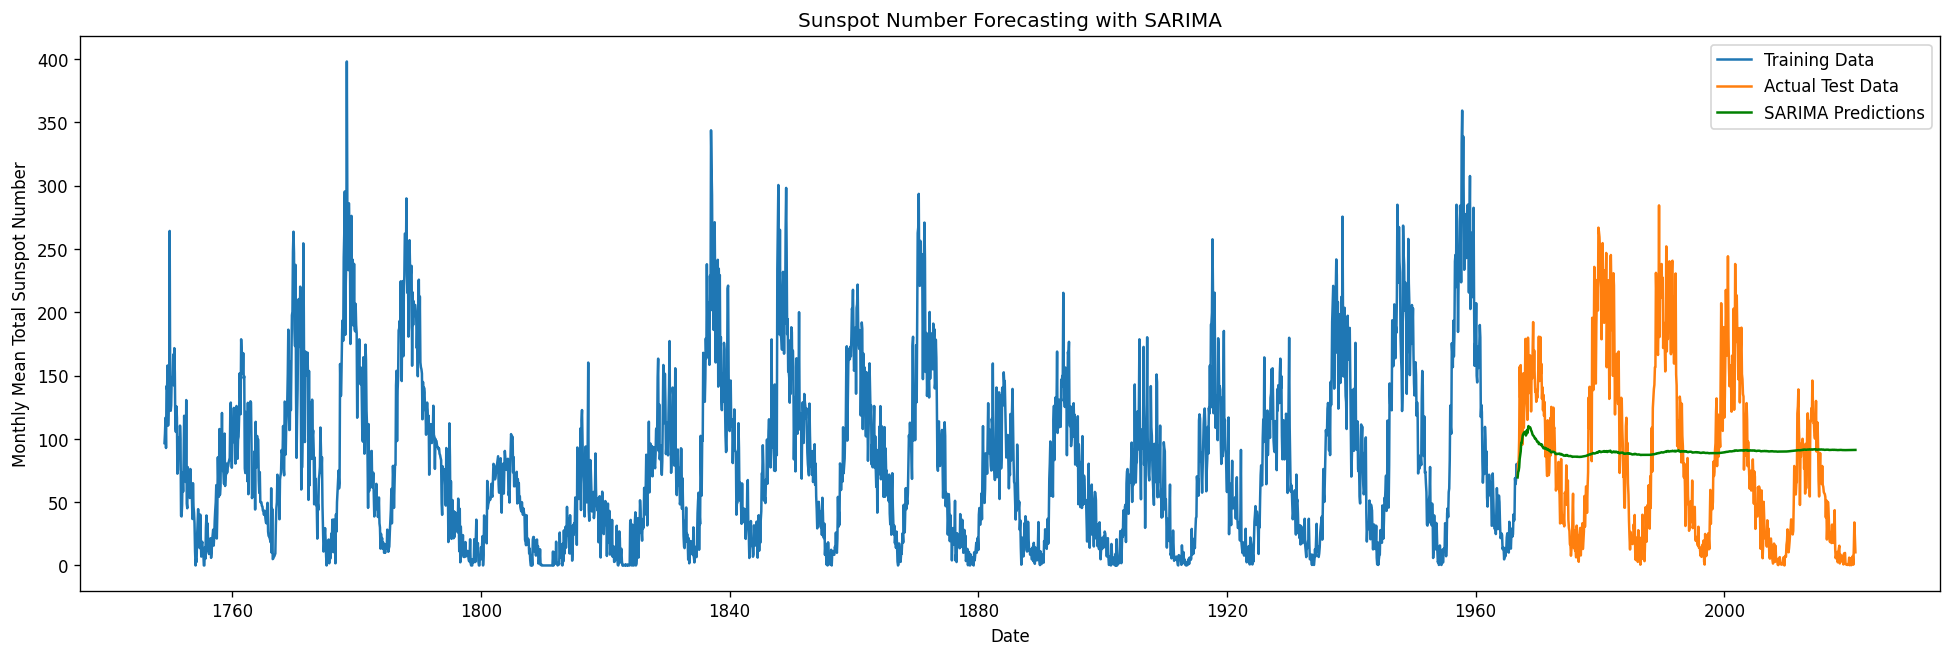


I punti in cui le predizioni SARIMA si scostano significativamente dai dati reali (differenza > 50) sono:
Data: 1967-01-31 00:00:00, Valore Reale: 157.00, Predizione SARIMA: 84.25, Differenza: 72.75
Data: 1967-03-31 00:00:00, Valore Reale: 158.30, Predizione SARIMA: 90.09, Differenza: 68.21
Data: 1967-12-31 00:00:00, Valore Reale: 179.00, Predizione SARIMA: 105.45, Differenza: 73.55
Data: 1968-01-31 00:00:00, Valore Reale: 172.50, Predizione SARIMA: 102.68, Differenza: 69.82
Data: 1968-02-29 00:00:00, Valore Reale: 158.50, Predizione SARIMA: 104.31, Differenza: 54.19
Data: 1968-05-31 00:00:00, Valore Reale: 180.00, Predizione SARIMA: 107.79, Differenza: 72.21
Data: 1968-09-30 00:00:00, Valore Reale: 166.00, Predizione SARIMA: 109.20, Differenza: 56.80
Data: 1969-02-28 00:00:00, Valore Reale: 170.50, Predizione SARIMA: 103.30, Differenza: 67.20
Data: 1969-03-31 00:00:00, Valore Reale: 192.30, Predizione SARIMA: 102.69, Differenza: 89.61
Data: 1969-05-31 00:00:00, Valore Reale: 169.90, 

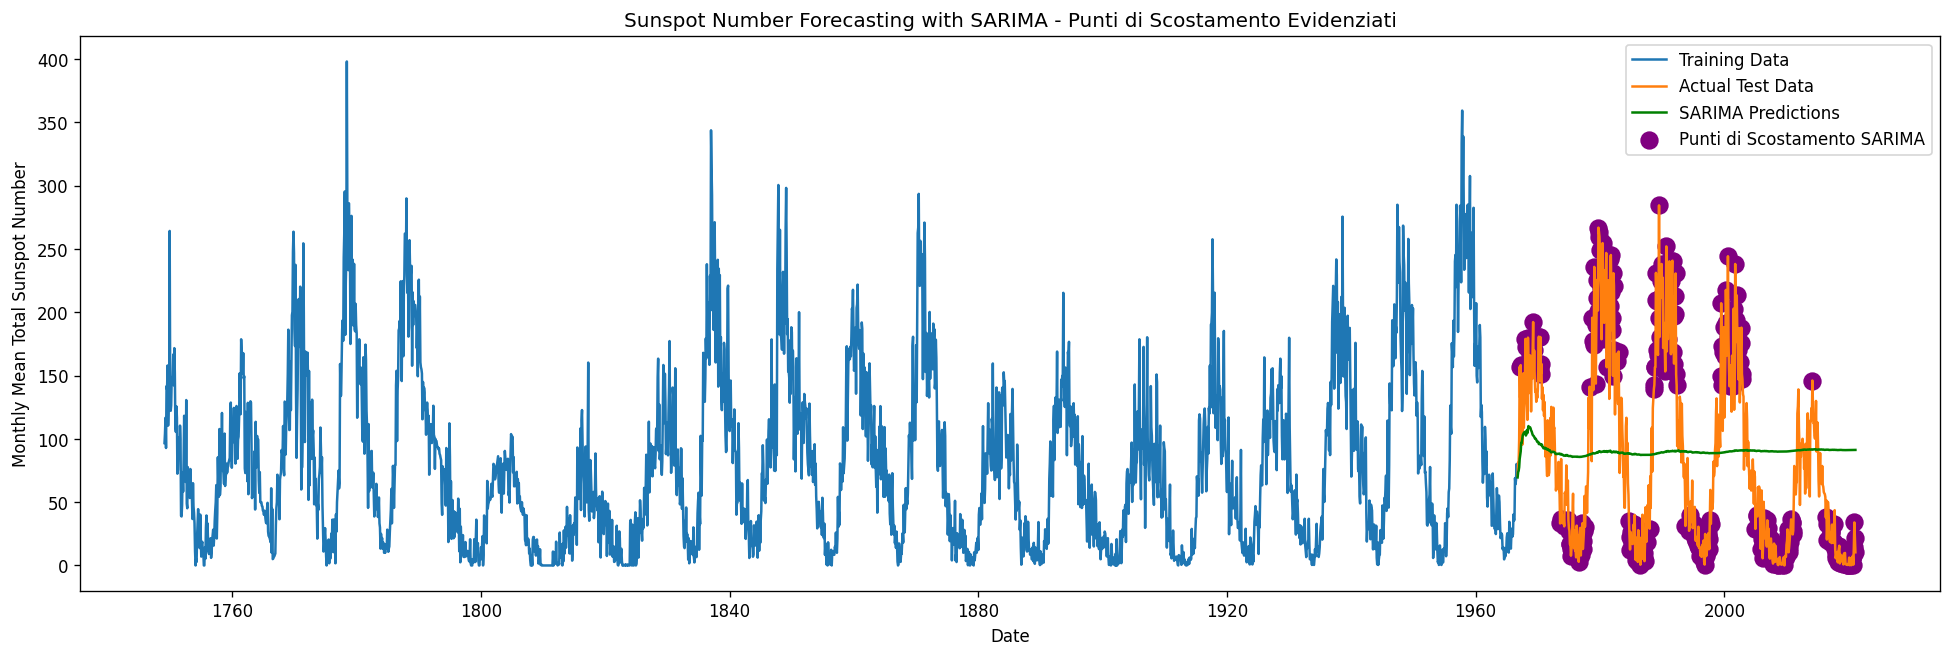


Il punto con il massimo scostamento per SARIMA è alla data: 1989-06-30 00:00:00
Valore Reale: 284.50, Predizione SARIMA: 88.77, Massimo Scostamento: 195.73


In [37]:


from statsmodels.tsa.statespace.sarimax import SARIMAX
df_seasonal_diff = df['Monthly Mean Total Sunspot Number'].diff(periods=132).dropna()
result_seasonal = adfuller(df_seasonal_diff)
print('\nADF Statistic (Seasonal Diff): %f' % result_seasonal[0])
print('p-value (Seasonal Diff): %f' % result_seasonal[1])
print('Critical Values (Seasonal Diff):')
for key, value in result_seasonal[4].items():
  print('\t%s: %.3f' % (key, value))
plt.figure(figsize=(20, 7))
plt.subplot(211)
plot_acf(df_seasonal_diff, lags=200, ax=plt.gca())
plt.title('ACF after Seasonal Differencing (s=132)')
plt.subplot(212)
plot_pacf(df_seasonal_diff, lags=200, ax=plt.gca())
plt.title('PACF after Seasonal Differencing (s=132)')
plt.show()
sarima_model = SARIMAX(train, order=(5, 0, 29), seasonal_order=(1, 0, 1, 132), enforce_stationarity=False, enforce_invertibility=False)
sarima_model_fit = sarima_model.fit(disp=False) # disp=False per non mostrare output intermedi durante il fitting
print(sarima_model_fit.summary())
sarima_predictions = sarima_model_fit.predict(start=test.index.min(), end=test.index.max())
plt.figure(figsize=(20, 6))
plt.plot(df['Monthly Mean Total Sunspot Number'], label='Original')
plt.plot(sarima_predictions, color='green', label='SARIMA Predictions')
plt.xlabel('Year')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.title('Forecast using SARIMA')
plt.legend()
plt.show()
sarima_mae = mean_absolute_error(test, sarima_predictions)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_predictions))
print(f"SARIMA MAE: {sarima_mae}")
print(f"SARIMA RMSE: {sarima_rmse}")
plt.figure(figsize=(20, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Test Data')
plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', color='green')
plt.title('Sunspot Number Forecasting with SARIMA')
plt.xlabel('Date')
plt.ylabel('Monthly Mean Total Sunspot Number')
plt.legend()
plt.show()
soglia_differenza_sarima = 50 # Esempio di soglia
differenza_assoluta_sarima = abs(test - sarima_predictions)
indici_scostamento_sarima = differenza_assoluta_sarima[differenza_assoluta_sarima > soglia_differenza_sarima].index
if not indici_scostamento_sarima.empty:
  print(f"\nI punti in cui le predizioni SARIMA si scostano significativamente dai dati reali (differenza > {soglia_differenza_sarima}) sono:")
  for indice in indici_scostamento_sarima:
    print(f"Data: {indice}, Valore Reale: {test.loc[indice]:.2f}, Predizione SARIMA: {sarima_predictions.loc[indice]:.2f}, Differenza: {differenza_assoluta_sarima.loc[indice]:.2f}")
  plt.figure(figsize=(20, 6))
  plt.plot(train.index, train, label='Training Data')
  plt.plot(test.index, test, label='Actual Test Data')
  plt.plot(test.index, sarima_predictions, label='SARIMA Predictions', color='green')
  plt.scatter(indici_scostamento_sarima, test.loc[indici_scostamento_sarima], color='purple', s=100, label='Punti di Scostamento SARIMA') # Evidenzia i punti di scostamento
  plt.title('Sunspot Number Forecasting with SARIMA - Punti di Scostamento Evidenziati')
  plt.xlabel('Date')
  plt.ylabel('Monthly Mean Total Sunspot Number')
  plt.legend()
  plt.show()
else:
  print("\nNon ci sono punti in cui le predizioni SARIMA si scostano significativamente dai dati reali con la soglia specificata.")
indice_max_scostamento_sarima = differenza_assoluta_sarima.idxmax()
valore_max_scostamento_sarima = differenza_assoluta_sarima.max()
if not differenza_assoluta_sarima.empty:
  print(f"\nIl punto con il massimo scostamento per SARIMA è alla data: {indice_max_scostamento_sarima}")
  print(f"Valore Reale: {test.loc[indice_max_scostamento_sarima]:.2f}, Predizione SARIMA: {sarima_predictions.loc[indice_max_scostamento_sarima]:.2f}, Massimo Scostamento: {valore_max_scostamento_sarima:.2f}")
else:
  print("\nNon ci sono differenze tra i dati reali e le predizioni SARIMA.")


Come previsto il miglior approccio è il modello ARIMA.